In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
N = 20

$c$ is concentration of solute

In [4]:
c = np.zeros(N)

In [5]:
c
c[N//2] = 1
c

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [6]:
x = np.arange(-N//2, N//2)

In [7]:
eaa0 = 1.0
ebb0 = 1.5
eab0 = 1.3
eaa_hat = 1
ebb_hat = 1
eab_hat = .5
width = 2
eaa = eaa0 + eaa_hat * np.exp(-(x/width)**2)
ebb = ebb0 + ebb_hat * np.exp(-(x/width)**2)
eab = eab0 + eab_hat * np.exp(-(x/width)**2)

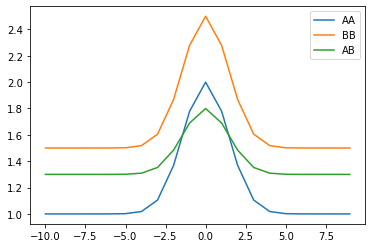

In [8]:
plt.plot(x, eaa, label='AA')
plt.plot(x, ebb, label='BB')
plt.plot(x, eab, label='AB')
plt.legend()

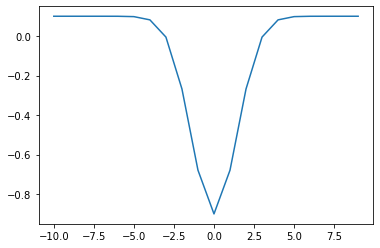

In [9]:
plt.plot(x, 2*eab - eaa - ebb)

In [10]:
def get_avg(x, d=1):
    return (x + np.roll(x, d))/2

In [125]:
class System:
    def __init__(self, N, eaa0=1.0, ebb0=1.5, eab0=1.3, width=2): 
        x = np.arange(-N//2, N//2)
        eaa_hat = 1
        ebb_hat = 1
        eab_hat = .5
      
        self.x = x
        self.aa = eaa0 + eaa_hat * np.exp(-(x/width)**2)
        self.bb = ebb0 + ebb_hat * np.exp(-(x/width)**2)
        self.ab = eab0 + eab_hat * np.exp(-(x/width)**2) 
        # for fcc
        self.z = 6  # intraplane
        self.zprime = 6 # interplane
        
    @property
    def aap(self):
#         return self.aa[:-1] * self.aa[1:]
        return get_avg(self.aa)
    
    @property
    def bbp(self):
#         return self.bb[:-1] * self.bb[1:]
        return get_avg(self.bb)
    
    @property
    def abp(self):
#         return self.ab[:-1] * self.ab[1:]
        return get_avg(self.ab)
        
    @property
    def w(self):
        return 2*self.ab - self.aa - self.bb
    
    @property
    def wp(self):
        return get_avg(self.w)

In [12]:
sys = System(x, eaa, ebb, eab)

In [13]:
def S(c):
    I = (c!=0) & (c!=1)
    s = np.zeros_like(c)
    s[I] = -(c[I] * np.log(c[I]) + (1-c[I])*np.log(1-c[I]))
    return s

In [14]:
S(c)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [15]:
def free_energy(c, sys, T):
    intra = sys.aa + (sys.bb - sys.aa) * c \
            + sys.w * c * (1-c)
    intra *= sys.z / 2
    # for now take inter and intra coefficients to be the same
    c1 = np.roll(c, 1)
    c_avg = (c + c1 )/2
    inter = sys.aap + (sys.bbp - sys.aap) * c_avg \
            + sys.wp * (c_avg - c * c1)
#     inter = sys.aa + (sys.bb - sys.aa) * c_avg \
#             + sys.w * ( c_avg - c * c1 )
    inter *= sys.zprime
    entrop = -T * S(c)
    return intra + get_avg(np.roll(inter, -1)) + entrop

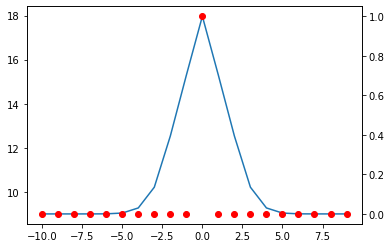

In [16]:
plt.plot(x, free_energy(c, sys, 1))
plt.twinx()
plt.plot(x, c, 'ro')

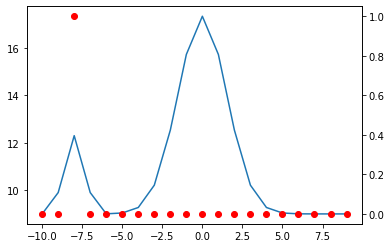

In [17]:
c[N//2] = 0
c[2] = 1
plt.plot(x, free_energy(c, sys, 1))
plt.twinx()
plt.plot(x, c, 'ro')

In [18]:
c_bulk = np.zeros(N)
c_bulk[2] = 1
c_bare = np.zeros(N)
c_gb = np.zeros(N)
c_gb[N//2] = 1

In [19]:
f_bare = free_energy(c_bare, sys, T=1e-2)
f_bulk = free_energy(c_bulk, sys, T=1e-2)
f_gb = free_energy(c_gb, sys, T=1e-2)

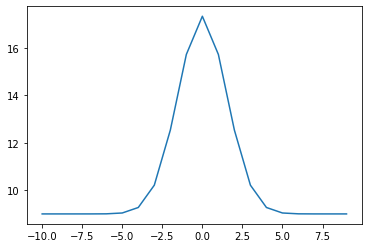

In [20]:
plt.plot(x, f_bare)

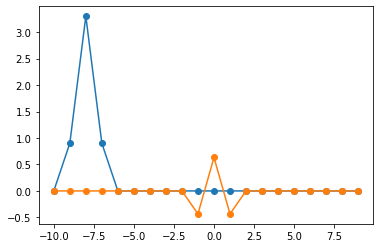

In [21]:
plt.plot(x, f_bulk - f_bare, 'o-')
plt.plot(x, f_gb - f_bare, 'o-')

In [22]:
def chem_pot(c, sys, T):
    intra = sys.z * (sys.ab - sys.aa - sys.w * c)
    inter = get_avg(sys.abp - sys.aap, -1) \
        + sys.wp * np.roll(c, 1) \
        + np.roll(sys.wp * c, -1)
    inter *= sys.zprime
    
    I = (c!=0) & (c!=1)
    s = np.zeros_like(c) # should be -inf
    s[I] = T * np.log(c[I]/(1-c[I]))
    return intra + inter + s

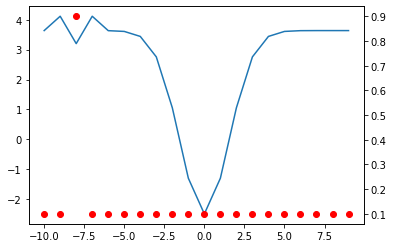

In [23]:
c = np.ones(N) * .1
c[2] = .9
plt.plot(x, chem_pot(c, sys, T=1e-2))
plt.twinx()
plt.plot(x, c, 'ro')

In [24]:
def flux(c, sys, T, M=1, d=1):
    mu = chem_pot(c, sys, T)
    return -M*c * (1 - np.roll(c, d)) * (np.roll(mu, d) - mu)

In [25]:
flux_left = lambda *a: flux(*a, d=-1)
flux_right = lambda *a: flux(*a, d=+1)

In [26]:
c = .1 * np.ones(N) + np.exp(- (x-x[N//2])**2) * .1

In [27]:
plt.rc('figure', figsize=(10,4))

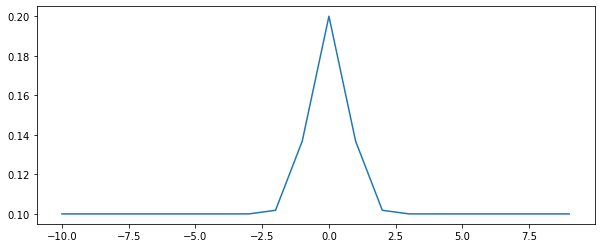

In [28]:
plt.plot(x, c)

In [31]:
sys_gb = sys
sys_bulk = System(x, np.ones(N)*eaa0, np.ones(N)*ebb0, np.ones(N)*eab0)

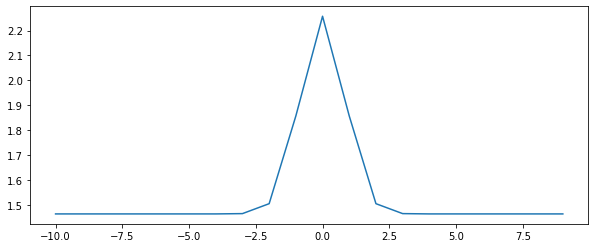

In [33]:
plt.plot(x, chem_pot(c, sys_bulk, T=1));

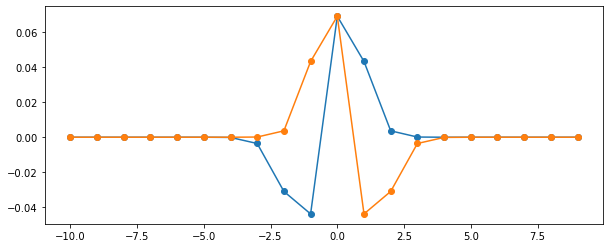

In [35]:
plt.plot(x, flux_left(c, sys_bulk, 1), 'o-')
plt.plot(x, flux_right(c, sys_bulk, 1), 'o-');

In [36]:
sum(flux_right(c, sys_bulk, 1))

0.037758587258992865

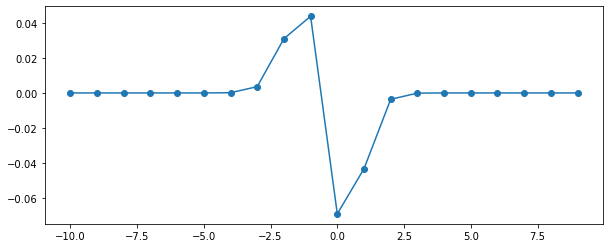

In [37]:
plt.plot(x, -flux_left(c, sys_bulk, 1), 'o-')

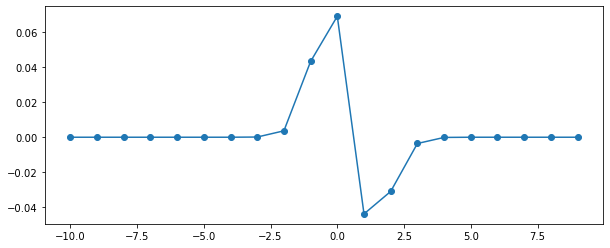

In [38]:
plt.plot(x, flux_right(c, sys_bulk, 1), 'o-')

In [39]:
def update_conc(c, sys, T, dt):
    dc = flux_left(c, sys, T) - np.roll(flux_left(c, sys, T), 1) \
       + flux_right(c, sys, T) - np.roll(flux_right(c, sys, T), -1)
    return c-dc * dt

In [40]:
sum(update_conc(c, sys_bulk, T=1, dt=1))

2.1772637204826655

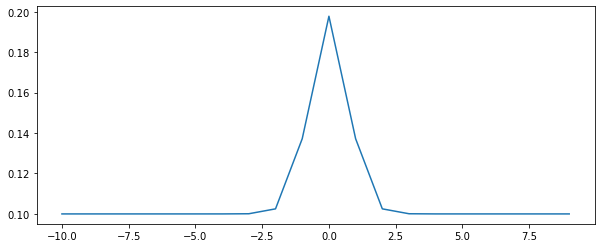

In [41]:
plt.plot(x, update_conc(c, sys_bulk, T=1, dt=1e-2))

In [42]:
c = .1 * np.ones(N) + np.exp(- (x-x[N//2])**2) * .1

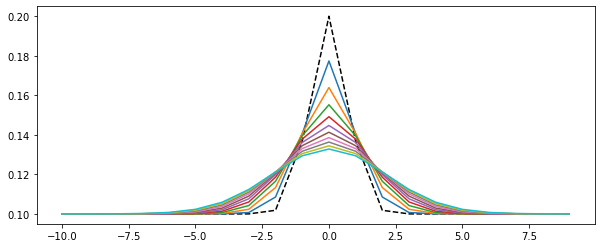

In [43]:
# c[N//2] = .9
plt.plot(x, c, 'k--')
for i in range(10):
    c = update_conc(c, sys_bulk, T=1, dt=1e-1)
    plt.plot(x, c)

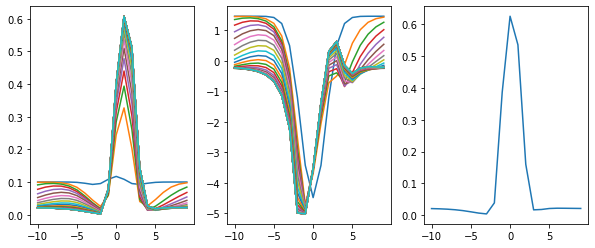

In [79]:
c = .1 * np.ones(N)
i_GB_vel = 25
plt.plot(x, c, 'k--')
s1 = plt.subplot(1,3,1)
s2 = plt.subplot(1,3,2)
s3 = plt.subplot(1,3,3)
count = 0
for i in range(1000):
    if i % i_GB_vel==0:
        c = np.roll(c, 1)
        count += 1
    c = update_conc(c, sys_gb, T=1, dt=4e-2)
    if i %i_GB_vel==0: 
        s1.plot(x, c, label=f'{i}')
        s2.plot(x, chem_pot(c, sys_gb, T=1))
s3.plot(x, c)        
# s1.set_yscale('log');        
# s1.legend();    

In [104]:
1/(25 * dt)

4.0

In [108]:
class GB_mobile:
    def __init__(self, sys, c_0=0.1, c=None, v_GB=25, dt=4e-2, n_steps=1000, T=1):
        if c is None:
            c = c_0 * np.ones_like(sys.x)

        i_GB = int(1/(v_GB * dt))
        print (i_GB)
        for i in range(n_steps):
            if i % i_GB==0:
                c = np.roll(c, 1)
            c = update_conc(c, sys, T=T, dt=dt)
        
        self.sys = sys
        self.x = sys.x
        self.c_0 = c_0
        self.c = c
        self.mu = chem_pot(c, sys, T=T)
        self.e_free = free_energy(c, sys, T)
    
        
    def plot_c(self):
        s1 = plt.subplot(1,3,1)
        s2 = plt.subplot(1,3,2)
        s3 = plt.subplot(1,3,3)
        s1.plot(self.x, self.c)
        s2.plot(self.x, self.mu)
        s3.plot(self.x, self.e_free)
        
        
        

2500000000
25
12
5


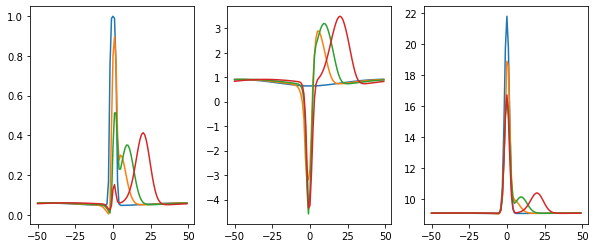

In [130]:
T = 1
dt = 4e-2
n_steps = 100

sys_gb = System(N=100)

gb_0 = GB_mobile(sys_gb, v_GB=1e-8, T=T, dt=dt, n_steps=10000)
gb_1 = GB_mobile(sys_gb, c=gb_0.c, v_GB=1, n_steps=n_steps, T=T, dt=dt)
gb_2 = GB_mobile(sys_gb, c=gb_0.c, v_GB=2, n_steps=n_steps, T=T, dt=dt)
gb_5 = GB_mobile(sys_gb, c=gb_0.c, v_GB=5, n_steps=n_steps, T=T, dt=dt)
gb_0.plot_c()
gb_1.plot_c()
gb_2.plot_c()
gb_5.plot_c()


- grand canonical boundary conditions
- measure excess GB concentration as function of GB velocity
- extend concept to Master equation (relate it to PES)
- extend to 2d/3d system

In [221]:
plt.rc('figure', figsize=(10,10))

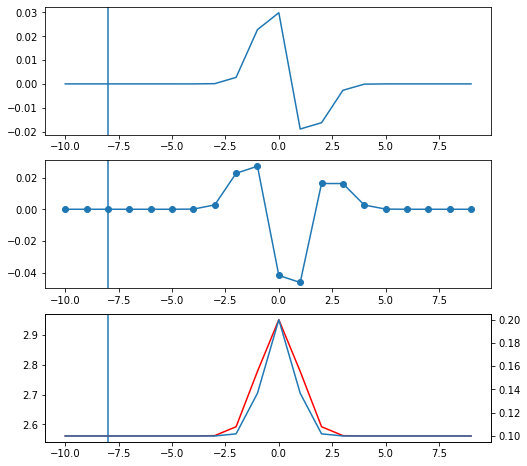

In [244]:
T=.5
plt.subplot(311)
J = flux(c, sys_bulk, T=T)
plt.axvline(x[2])
plt.plot(x, J)
plt.subplot(312)
plt.axvline(x[2])
plt.plot(x, np.roll(np.roll(J, -2) - J, 1), 'o-' )
plt.subplot(313)
plt.axvline(x[2])
plt.plot(x, chem_pot(c, sys_bulk, T=T), 'r')
plt.twinx()
plt.plot(x, c)

In [237]:
def update_conc(c, sys, T, dt=1e-2):
    J = flux(c, sys, T)
    #dc = np.roll(J, -1) + np.roll(J, 1) - 2*J
    dc = np.roll(J, -1) - J
    return c + dt * dc

In [224]:
plt.rc('figure', figsize=(8,8))

In [242]:
c = .1 * np.ones(N) + np.exp(- (x-x[N//2])**2) * .1

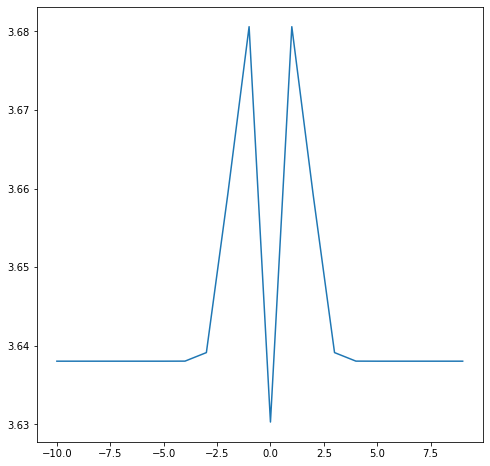

In [243]:
plt.plot(x, chem_pot(c, sys_bulk, T=1e-2))



/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


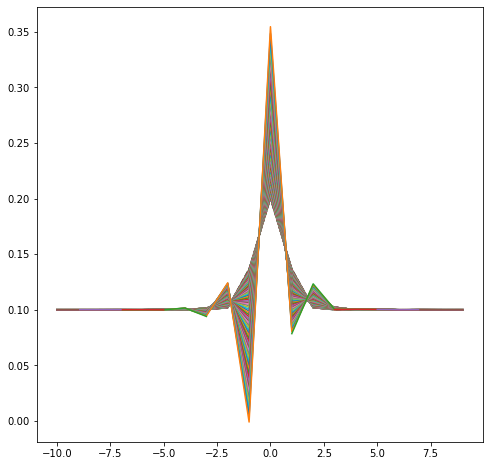

In [238]:
# c[N//2] = .9
plt.plot(x, c, 'k--')
for i in range(100):
    c = update_conc(c, sys_bulk, T=1e-2, dt=4e-2)
    plt.plot(x, c)